In [64]:
import warnings
warnings.filterwarnings('ignore')

In [65]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

In [66]:
import os
from dotenv import load_dotenv
load_dotenv()
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
GROQ_API_KEY=os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY=os.getenv("LANGCHAIN_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"]= GROQ_API_KEY
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

In [67]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="Gemma2-9b-It")

In [68]:
llm.invoke("What's up?").content

"Not much, just hanging out in the digital world, waiting to answer your questions and have a conversation!\n\nWhat about you? What's going on in your world today?\n"

In [69]:
url = "https://lilianweng.github.io/posts/2023-06-23-agent/"
WebBaseLoader(url).load()

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [70]:
WebBaseLoader(url).load()[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'title': "LLM Powered Autonomous Agents | Lil'Log",
 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\

In [71]:
WebBaseLoader(url).load()[0].metadata["description"]

'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizing short-term memory of the model 

In [72]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

In [73]:
docs = [WebBaseLoader(url).load() for url in urls]

In [74]:
docs

[[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final res

In [75]:
docs_list = [item for sublist in docs for item in sublist]

In [76]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100, chunk_overlap=25)

In [77]:
doc_splits = text_splitter.split_documents(docs_list)

In [78]:
doc_splits

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [79]:
vectorstore = Chroma.from_documents(
    documents = doc_splits,
    collection_name = "rag-chrome",
    embedding = embeddings
)

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [80]:
retriever = vectorstore.as_retriever()

In [81]:
retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="retrieve_blog_post",
    description="Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response."
)

In [82]:
tools = [retriever_tool]
retrieve = ToolNode([retriever_tool])


#### **Code Breakdown:**

```python
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
```

This code defines a class `AgentState` that is a **`TypedDict`**, which is a special kind of dictionary with fixed keys and value types, used to provide better type safety and autocompletion in Python.

Here’s a breakdown of each part:

---

#### **1. `AgentState(TypedDict)`**
- **`TypedDict`**: This is a special class provided by `typing` that allows you to define dictionaries where each key has a fixed type. The dictionary keys are usually predefined, and each key must have a specified type.

  - `AgentState` here is a subclass of `TypedDict`, meaning `AgentState` will represent a dictionary where the types of its values are enforced.

  - Example:
    ```python
    agent_state = AgentState(messages=["Message 1", "Message 2"])  # This would be valid.
    ```

---

#### **2. `messages: Annotated[Sequence[BaseMessage], add_messages]`**
- **`messages`**: This is a key in the `AgentState` dictionary. It holds a sequence (like a list or tuple) of `BaseMessage` objects.
  
- **`Annotated[...]`**: `Annotated` is used to attach additional metadata or annotations to the type. It’s a way to add extra information to the type system without affecting the actual type. In this case, it provides metadata for the `messages` field. 

  - The **`Annotated`** wrapper allows you to define a type and also include additional information that might be used by tools like static analyzers or for other purposes like validation.

- **`Sequence[BaseMessage]`**: This indicates that `messages` should be a sequence (e.g., a list or tuple) of `BaseMessage` objects.

  - **`BaseMessage`** is likely a class that represents a message in the context of your program. It could have fields like `content`, `sender`, `timestamp`, etc.
  
- **`add_messages`**: This is a special annotation (or metadata) that likely refers to some function or constant that’s being added as additional context. The specific role of `add_messages` will depend on how it's defined elsewhere in the codebase.

  - **`add_messages`** could be a function, validator, or modifier that helps manage or process the messages in some way, but it's not directly modifying the type of `messages`. It's simply metadata for the type checker or other parts of the system.

  - For example, if `add_messages` were a function, it could be used in a custom decorator, validation system, or simply as an indication of how to handle messages.

---

#### **Putting It All Together:**

- **`AgentState`** is a dictionary where one of the keys, `messages`, is specifically typed to be a **sequence of `BaseMessage`** objects. The sequence is annotated with **`add_messages`**, which provides additional metadata but doesn’t affect the type directly.
  
- **Example of `AgentState` usage:**

```python
from typing import TypedDict, Sequence
from typing_extensions import Annotated

class BaseMessage:
    def __init__(self, content: str):
        self.content = content

# Defining the `AgentState` TypedDict
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], "add_messages"]

# Example usage
message1 = BaseMessage("Hello, world!")
message2 = BaseMessage("How are you?")
state = AgentState(messages=[message1, message2])

print(state)
```

In the above code:
- `AgentState` is a dictionary with a `messages` field that is a sequence of `BaseMessage` objects.
- `add_messages` is metadata associated with the `messages` field, which can help guide the usage or interpretation of the data.

---

#### **Summary:**
- `AgentState` is a dictionary where the `messages` key holds a sequence of `BaseMessage` objects.
- `Annotated[Sequence[BaseMessage], add_messages]` means that `messages` is a sequence of `BaseMessage` objects with additional metadata (`add_messages`).
- The annotation `add_messages` provides extra context or metadata that doesn't alter the type directly but can be used for purposes like validation or other system-specific behavior.


In [83]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


In [84]:
def ai_assistant(state:AgentState):
    print("---CALL AGENT---")
    messages = state['messages']
    
    if len(messages)>1:
        last_message = messages[-1]
        question = last_message.content
        prompt=PromptTemplate(
        template="""You are a helpful assistant whatever question has been asked to find out that in the given question and answer.
                        Here is the question:{question}
                        """,
                        input_variables=["question"]
                        )
            
        chain = prompt | llm
    
        response=chain.invoke({"question": question})
        return {"messages": [response]}
    else:
        llm_with_tool = llm.bind_tools(tools)
        response = llm_with_tool.invoke(messages)
        #response=handle_query(messages)
        return {"messages": [response]}

In [85]:
class grade(BaseMessage):
    binary_score: str = Field(description = "Relevence score 'yes' or 'no'")

In [86]:
def grade_documents(state:AgentState)->Literal["Output_Generator", "Query_Rewriter"]:
    llm_with_structure_op=llm.with_structured_output(grade)
    
    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
    chain = prompt | llm_with_structure_op
    
    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generator" #this should be a node name
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewriter" #this should be a node namee

In [87]:
hub.pull("rlm/rag-prompt").pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [88]:
def generate(state:AgentState):
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content 
    last_message = messages[-1]
    docs = last_message.content
    prompt = hub.pull("rlm/rag-prompt")
    rag_chain = prompt | llm
    response = rag_chain.invoke({"context": docs, "question": question})
    print(f"this is my response:{response}")
    
    return {"messages": [response]}

In [89]:
from langchain_core.messages import  HumanMessage
def rewrite(state:AgentState):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content
    
    message = [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question: """)
       ]
    response = llm.invoke(message)
    return {"messages": [response]}

In [90]:
workflow = StateGraph(AgentState)
workflow.add_node("My_Ai_Assistant", ai_assistant)
workflow.add_node("Vector_Retriever", retrieve) 
workflow.add_node("Output_Generator", generate)
workflow.add_node("Query_Rewriter", rewrite)

In [91]:
workflow.add_edge(START, "My_Ai_Assistant")
workflow.add_conditional_edges("My_Ai_Assistant", tools_condition, {"tools": "Vector_Retriever", END:END,})
workflow.add_conditional_edges("Vector_Retriever", grade_documents, {"generator": "Output_Generator", "rewriter": "Query_Rewriter"})
workflow.add_edge("Output_Generator", END)
workflow.add_edge("Query_Rewriter", "My_Ai_Assistant")

In [92]:
app = workflow.compile()

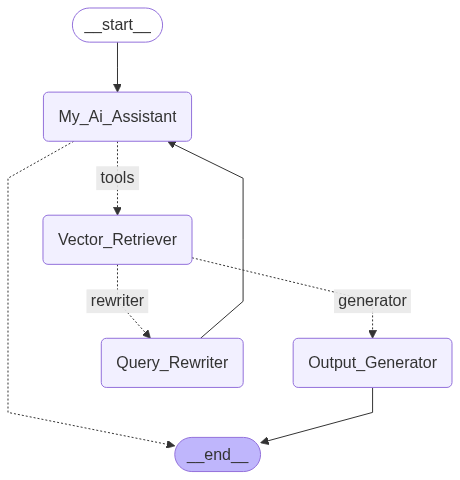

In [93]:
from IPython.display import Image, display
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print(e)

In [94]:
app.invoke({"messages":["What is a Autonomous Agent?"]})

---CALL AGENT---
---DECISION: DOCS NOT RELEVANT---
---TRANSFORM QUERY---
---CALL AGENT---


{'messages': [HumanMessage(content='What is a Autonomous Agent?', additional_kwargs={}, response_metadata={}, id='1d9ad7c9-9d27-4dbe-9a0a-f54ca12a4642'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'r28z73a6w', 'function': {'arguments': '{"query":"What is an autonomous agent?"}', 'name': 'retrieve_blog_post'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 1038, 'total_tokens': 1126, 'completion_time': 0.16, 'prompt_time': 0.05487393, 'queue_time': 0.266201252, 'total_time': 0.21487393}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f6605c6f-b34a-4d31-bf3f-7b62e8c1e37e-0', tool_calls=[{'name': 'retrieve_blog_post', 'args': {'query': 'What is an autonomous agent?'}, 'id': 'r28z73a6w', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1038, 'output_tokens': 88, 'total_tokens': 1126}),
  ToolMessage(content='Posts\n\n\n\n\nArchive

In [95]:
app.invoke({"messages":["what is a prompt engineering explain me in terms of agents and langchain?"]})

---CALL AGENT---


BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool-use>\n{\n\t"tool_call": {\n\t\t"id": "pending",\n\t\t"type": "function",\n\t\t"function": {\n\t\t\t"name": "grade"\n\t\t},\n\t\t"parameters": {\n\t\t\t"content": "Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\n\nPrompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\n\nPrompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\n\nOpenAI Cookbook has many in-depth examples for how to utilize LLM efficiently.\nLangChain, a library for combining language models with other components to build applications.\nPrompt Engineering Guide repo contains a pretty comprehensive collection of education materials on prompt engineering.\nlearnprompting.org\nPromptPerfect\nSemantic Kernel",\n\t\t\t"type": "text"\n\t\t}\n\t}\n}\n</tool-use>\n'}}

In [ ]:
app.invoke({"messages":["what is capital of France?"]})

---CALL AGENT---
Message from the garder: [HumanMessage(content='what is capital of France?', additional_kwargs={}, response_metadata={}, id='47c4ab83-165c-470d-b9eb-78f95ad0e4d4'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '5gppwb9e0', 'function': {'arguments': '{"query":"What is the capital of France?"}', 'name': 'retrieve_blog_post'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 1038, 'total_tokens': 1127, 'completion_time': 0.161818182, 'prompt_time': 0.044143921, 'queue_time': 0.160608027, 'total_time': 0.205962103}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--09ff3245-9817-46f0-88eb-cc9d6eaf16d0-0', tool_calls=[{'name': 'retrieve_blog_post', 'args': {'query': 'What is the capital of France?'}, 'id': '5gppwb9e0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1038, 'output_tokens': 89, 'total_tokens': 1127}), ToolMe

{'messages': [HumanMessage(content='what is capital of France?', additional_kwargs={}, response_metadata={}, id='47c4ab83-165c-470d-b9eb-78f95ad0e4d4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '5gppwb9e0', 'function': {'arguments': '{"query":"What is the capital of France?"}', 'name': 'retrieve_blog_post'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 1038, 'total_tokens': 1127, 'completion_time': 0.161818182, 'prompt_time': 0.044143921, 'queue_time': 0.160608027, 'total_time': 0.205962103}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--09ff3245-9817-46f0-88eb-cc9d6eaf16d0-0', tool_calls=[{'name': 'retrieve_blog_post', 'args': {'query': 'What is the capital of France?'}, 'id': '5gppwb9e0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1038, 'output_tokens': 89, 'total_tokens': 1127}),
  ToolMessage(content='Definition